<a href="https://colab.research.google.com/github/marcialContrerasERN/MLfachada/blob/master/maintest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Celda indispensable siempre

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
import pandas as pd
from math import ceil 

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
image_dir = '/content/drive/My Drive/Colab Notebooks/outimags'

# para imagenes de tamano variable usar None
image_size = 224
# para imagenes de colores usar 3
ncanales = 3

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Entrenar ultimas cuatro capas de máquina pre entrenada, y abundar los datos de entrenamiento

In [0]:
# celda opcional, para revisar que se tiene acceso a la carpeta de imagenes
checar_all_image_paths = False

import pathlib
import os
data_root = pathlib.Path(image_dir)
existe = os.path.exists(data_root)
print("checando %s .. %s"%(data_root,str(existe)))
if checar_all_image_paths:
  all_image_paths = list(data_root.glob('*.jpeg'))
  print("En la carpeta %s hay %d imagenes jpeg"%(image_dir,len(all_image_paths)))

In [0]:
# celda de uso unico, generar modelo nuevo
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
# cargar pesos del modelo VGG16 entrenado para el dataset Imagenet, excluir la ultima capa (de clasificacion)


vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, ncanales))

# Entrenar solo las ultimas cuatro capas del modelo
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
# Crear un modelo nuevo
model = models.Sequential()

# Agregar el modelo VGG como base
model.add(vgg_conv)

# Agregar capa que acomoda la matriz (las dimensiones que sean) como vector
model.add(layers.Flatten())
# Agregar capa de red neuronal densa, que devuelve algo de tamano 1024
# funcion de activacion ReLU (rectified linear unit)
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
# Agregar capa que que diezma la mita de los datos, es para prevenir subreajuste
model.add(layers.Dropout(0.5))
# funcion de activacion que convierte las calificaciones lógicas a un vector de
# distribución de probabilidades de la lista de posibles resultados. Es la fun-
# cion de normalización default
# para y = [val1, val2, ... , valn]
# S(y_i) = e^(y_i) / Sum_j(e^(y_j))
# para y = [0.1, 1.0, 2.0], el resultado es [0.66, 0.24, 0.1]
model.add(layers.Dense(3, activation='softmax'))

# Mostrar cada capa y si es entrenable
for layer in vgg_conv.layers:
    print(layer, layer.trainable)
    
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Cargar el archivo con la lista (limpia) de archivos y correspondiene etiqueta

In [0]:
# celda indispensable
# funcion para cargar imagenes, asociarlas con la base de datos y crear
# objetos que le dan los datos de entrenamiento y validación al modelo

def preparar_data(url,image_dir,validation_split,train_batchsize,val_batchsize,image_size):
  image_dataframe = pd.read_csv(url)

  print("Se toman "+str(len(image_dataframe))+" imagenes")
  print(image_dataframe[:4])
  print("...")
  print("El %g se toman para validacion"%(validation_split))


  # Docs: Generate batches of tensor image data with real-time data augmentation. 
  # El CPU aumetar los datos 'on the fly' y los pasa al GPU, cada paso del epoch
  # (steps_per_epoch) recibe un batch de datos ligeramente distintos.
  datagen = ImageDataGenerator(
        rescale=1./255,        # multiply the data by the value provided (after applying all other transformations). Para normalizar la escala de color
        rotation_range=10,     # Int. Degree range for random rotations.
        width_shift_range=10,  # int: integer number of pixels from interval  (-width_shift_range, +width_shift_range) , plusborder
        height_shift_range=10, # igual anterior
        brightness_range=(1,5),# Tuple or list of two floats. Range for picking a brightness shift value from.
        shear_range=0.5,       # Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
        zoom_range=0.1,        # Float = [1-zoom_range, 1+zoom_range]
        fill_mode='reflect',   # Points outside the boundaries of the input are filled according to 'reflect': abcddcba|abcd|dcbaabcd
        horizontal_flip=True,  # Boolean. Randomly flip inputs horizontally.
        vertical_flip=False,   # Boolean. Randomly flip inputs vertically.
        validation_split=validation_split)  # Float. Fraction of images reserved for validation 


  # dispensador de datos para entrenamiento y validacion
  print("train:")
  train_generator = datagen.flow_from_dataframe(
      dataframe=image_dataframe, # Pandas dataframe containing the filepaths relative to  directory
                                 # of the images in a string column. It should include y_col column 
                                 # with the class/es of each image. Values in column can be string
      directory=image_dir, # string, path to the directory to read images from
      x_col="id",          # nombre de columna con nombres de archivo
      y_col="label",       # nombre de columna con etiqueta de categoria
      class_mode="categorical", # 2D numpy array of one-hot encoded labels. Supports multi-label output.
      color_mode='rgb',
      target_size=(image_size,image_size),
      batch_size=train_batchsize, # size of the batches of data (default: 32). How many images loaded per batch
      shuffle=True,               # whether to shuffle the data (default: True)
      save_to_dir=None, # None or str. directory to which to save the augmented pictures being generated 
      subset="training")
  print("Para entrenamiento se toman %d imagenes"%train_generator.n)
  print("La cantidad de muestras que genera es %d"%train_generator.samples)
  
  
  print("validation:")
  validation_generator = datagen.flow_from_dataframe(
      dataframe=image_dataframe,
      directory=image_dir,
      x_col="id",
      y_col="label",
      class_mode="categorical",
      color_mode='rgb',
      target_size=(image_size,image_size),
      batch_size=val_batchsize,
      shuffle=True,
      subset="validation")
  print("Para validacion se reservan %d imagenes"%validation_generator.n)
  print("La cantidad de muestras que genera es %d"%validation_generator.samples)
  
  return image_dataframe,datagen,train_generator,validation_generator

print("ejecutado")

ejecutado


In [0]:
# celda indispensable, reusable
# esta celda se puede modificar y ejecutar de nuevo, para ensayar otro minibatch
validation_split = 0.3

# ruta 'raw' a tabla con columnas (nombre de archivo, etiqueta)
#url = 'https://raw.githubusercontent.com/marcialContrerasERN/MLfachada/master/lista_pbdebil_todo_minsize100.csv'
#url = 'https://raw.githubusercontent.com/marcialContrerasERN/MLfachada/master/subset1.csv'
#url = 'https://raw.githubusercontent.com/marcialContrerasERN/MLfachada/master/lista_pbdebil_todo_clean7mayo_subset.csv' # (100) 120
#url = 'https://raw.githubusercontent.com/marcialContrerasERN/MLfachada/master/lista_pbdebil_todo_clean7mayo_subset_2.csv' # 180
#url = 'https://raw.githubusercontent.com/marcialContrerasERN/MLfachada/master/lista_pbdebil_todo_clean7mayo_subset_3.csv' #190
url = 'https://raw.githubusercontent.com/marcialContrerasERN/MLfachada/master/lista_pbdebil_todo_clean7mayo_subset_4.csv' #100 +30
#url = 'https://raw.githubusercontent.com/marcialContrerasERN/MLfachada/master/lista_pbdebil_todo_clean7mayo_subset_5.csv' #150
#url = 'https://raw.githubusercontent.com/marcialContrerasERN/MLfachada/master/lista_pbdebil_todo_clean7mayo_subset_6.csv' #120
#url = 'https://raw.githubusercontent.com/marcialContrerasERN/MLfachada/master/lista_pbdebil_todo_clean7mayo_subset_7.csv' #90
#url = 'https://raw.githubusercontent.com/marcialContrerasERN/MLfachada/master/lista_pbdebil_todo_clean7mayo_subset_8.csv' #60 (30)
#url = 'https://raw.githubusercontent.com/marcialContrerasERN/MLfachada/master/lista_pbdebil_todo_clean7mayo_subset_9.csv' #90 +30
outn = 'test3'


train_batchsize = 32
val_batchsize = 10

image_dataframe,datagen,train_generator,validation_generator = preparar_data(
    url,image_dir,validation_split,train_batchsize,val_batchsize,image_size)
print("... ready")

Se toman 3131 imagenes
                     id label
0  026-214.25_pic4.jpeg    _0
1  026-214.21_pic2.jpeg    _0
2  026-214.23_pic2.jpeg    _0
3  026-214.24_pic5.jpeg    _0
...
El 0.3 se toman para validacion
train:
Found 2192 images belonging to 3 classes.
Para entrenamiento se toman 2192 imagenes
La cantidad de muestras que genera es 2192
validation:
Found 939 images belonging to 3 classes.
Para validacion se reservan 939 imagenes
La cantidad de muestras que genera es 939
... ready


Una explicacion de cada algoritmo de optimacion esta en [towards data science](https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f), usamos:

adam: "Adaptive Moment Estimation", el cual:

*   Obtiene tasas de aprendizaje para cada parámetro, 
*   Estima el momentum del ajuste para cada parámetro y 
*   Previene que la tasa de aprendizaje sea demasiado pequeña.

Considerando el parámetro $\theta_t$ en el tiempo $t$, adam obtiene el primer momento (media) de su gradiente,
$$\hat{m}_t = \frac{m_t}{1-\beta_1^t}$$,
y el segundo momento (varianza no centrada),
$$\hat{\nu}_t = \frac{\nu_t}{1-\beta_2^t}$$
y actualiza los parámetros para el pasos siguiente de iteracion con la siguiente expresión:
$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{\nu}_t}+\epsilon}\hat{m}_t$$
donde $\eta$ es la tasa de aprendizaje, $\beta_1=0.9$, $\beta_2=0.999$ y $\epsilon$ = 10 * exp(-8)

In [0]:
# Celda de uso unico para modelo nuevo

# Compilar modelo
# AGUAS! esta funcion crea un nuevo modelo. Solo usarla para compenzar de cero

# Compilation transforms the simple sequence of layers that we defined into a 
# highly efficient series of matrix transforms in a format intended to be 
# executed on your GPU or CPU, depending on how Keras is configured.
#
#model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.RMSprop(lr=1e-4),
#              metrics=['acc'])

# una explicacion de cada algoritmo de optimacion es 
# https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f 
# adam: Adaptive Moment Estimation
#       obtiene tasas de aprendizaje para cada parámetro, 
#       estima el momentum del ajuste para cada parámetro y 
#       previene que la tasa de aprendizaje sea demasiado pequeña.

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']) # acc: categorical_accuracy
#checar que se podrá guardar el modelo entrenado
# model.save('/content/drive/My Drive/Colab Notebooks/test1_dataaugment_last4_layers_pbdebil0.h5')
model.save('/content/drive/My Drive/Colab Notebooks/{}.h5'.format(outn))
#guardar la arquitectura del modelo
with open('/content/drive/My Drive/Colab Notebooks/model_architecture_{}.json'.format(outn), 'w') as f:
    f.write(model.to_json())
print("compilado y guardado")

# inicializar variable donde se guardan las historias
histories = []

In [0]:
# celda Opcional: recuperar modelo desde archivo
from keras.models import load_model

#del model  
model = load_model('/content/drive/My Drive/Colab Notebooks/test3_end.h5')
#model = load_model('/content/drive/My Drive/Colab Notebooks/model_test3_epoch21.hdf5')


# este archivo contiene: arquitectura, pesos, loss-optimizer y estado
# se puede usar para reiniciar el calculo

print("cargado y listo para entrenar")

# Show a summary of the model. Check the number of trainable parameters
model.summary()

# celda opcional: recupear las historias
histories = []

import json
historiesin = json.load(open('/content/drive/My Drive/Colab Notebooks/{}_historyout.h5'.format(outn), 'r'))
class h:
  history = {'acc':[],'val_acc':[],'loss':[],'val_loss':[]}
h1 = h()
h1.history['acc'] = historiesin['acc']
h1.history['val_acc'] = historiesin['val_acc']
h1.history['loss'] = historiesin['loss']
h1.history['val_loss'] = historiesin['val_loss']
histories.append(h1)
print("historia cargada %g epochs"%len(h1.history['acc']))

cargado y listo para entrenar
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
Total params: 41,458,499
Trainable params: 33,823,235
Non-trainable params: 7,635,264
__________________________

In [0]:
# definir una funcion que guarde cada epoch que mejore la metrica de exito
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/model_latest_epoch.hdf5', 
    #filepath='/content/drive/My Drive/Colab Notebooks/model_%s_epoch{epoch:02d}.hdf5'%(outn), 
    verbose=1, 
    monitor='val_acc',
    mode='max',
    save_best_only=True, 
    period=1)

from keras.callbacks import EarlyStopping
mejor_no_mejora = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    verbose=0, 
    mode='min')

# definir una funcion para imprimir metricas de ajuste
import json
def plot_histories(histories):
  print("hay %g historias"%len(histories))
  acc=[];val_acc=[];loss=[];val_loss=[]
  for history in histories:
    [acc.append(v) for v in history.history['acc']];
    [val_acc.append(v) for v in history.history['val_acc']];
    [loss.append(v) for v in history.history['loss']];
    [val_loss.append(v) for v in history.history['val_loss']];
  epochs = range(len(acc))
  histout = {'acc':acc,'val_acc':val_acc, 'loss':loss, 'val_loss':val_loss}
  json.dump(histout, open('/content/drive/My Drive/Colab Notebooks/{}_historyout.h5'.format(outn), 'w'))
  
  fig = plt.figure(figsize=(17,4))
  fig.patch.set_facecolor('white')
  plt.plot(epochs, acc, 'b.', label='Training acc')
  plt.plot(epochs, val_acc, 'r.', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  fig = plt.figure(figsize=(17,4))
  plt.plot(epochs, loss, 'b.', label='Training loss')
  plt.plot(epochs, val_loss, 'r.', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  fig.patch.set_facecolor('white')

  plt.show()
print("ready...")

ready...


In [0]:
# Celda Iterable

# entrenar modelo
# steps_per_epoch: Total number of steps (batches of samples) to yield 
#                  from generator before declaring one epoch finished. 
#                  Usualmente ceil(num_samples / batch_size)
# epochs: Number of epochs to train the model. An epoch is an iteration over 
#         the entire data provided, as defined by steps_per_epoch.
#         epochs is to be understood as "final epoch". The model is not trained 
#         for a number of iterations given by epochs, but merely until the epoch
#         of index epochs is reached.
# workers: Maximum number of processes to spin up when use_multiprocessing = T
# initial_epoch: Epoch at which to start training (useful for resuming a previous training run).

steps_per_epoch=2*ceil(train_generator.samples/train_generator.batch_size)
print("steps_per_epoch = %g"%steps_per_epoch)

validation_steps=ceil(validation_generator.samples/validation_generator.batch_size)
print("validation_steps = %g"%validation_steps)

# Fit means adapt the weights on a training dataset
# The network is trained using the backpropagation algorithm and optimized 
# according to the optimization algorithm and loss function specified when 
# compiling the model.
# The backpropagation algorithm requires that the network be trained for a 
# specified number of epochs or exposures to the training dataset.
# Each epoch can be partitioned into groups of input-output pattern pairs called batches.
history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      workers=50,
      use_multiprocessing=True,
      verbose=2,
      initial_epoch=0,
      callbacks=[checkpointer])
# guardar el modelo
histories.append(history)
model.save('/content/drive/My Drive/Colab Notebooks/{}_end.h5'.format(outn))
print("guardado ...{}_end.h5".format(outn))
# nota: cuando se tienen nuevos datos se puede cargar este archivo, y continuar
# el entrenamiento con un nuevo minibatch

# graficar metricas y guardar historia
plot_histories(histories)

steps_per_epoch = 138
validation_steps = 94
Epoch 1/30

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



 - 90s - loss: 2.1973 - acc: 0.8637 - val_loss: 0.8573 - val_acc: 0.9468

Epoch 00001: val_acc improved from 0.94043 to 0.94681, saving model to /content/drive/My Drive/Colab Notebooks/model_latest_epoch.hdf5
Epoch 2/30
 - 77s - loss: 2.2849 - acc: 0.8582 - val_loss: 3.2236 - val_acc: 0.8000

Epoch 00002: val_acc did not improve from 0.94681
Epoch 3/30
 - 80s - loss: 3.0732 - acc: 0.8093 - val_loss: 4.9726 - val_acc: 0.6915

Epoch 00003: val_acc did not improve from 0.94681
Epoch 4/30
 - 76s - loss: 2.9126 - acc: 0.8193 - val_loss: 4.6983 - val_acc: 0.7085

Epoch 00004: val_acc did not improve from 0.94681
Epoch 5/30
 - 76s - loss: 3.4017 - acc: 0.7889 - val_loss: 4.0810 - val_acc: 0.7468

Epoch 00005: val_acc did not improve from 0.94681
Epoch 6/30
 - 76s - loss: 2.9418 - acc: 0.8175 - val_loss: 4.9383 - val_acc: 0.6936

Epoch 00006: val_acc did not improve from 0.94681
Epoch 7/30
 - 79s - loss: 3.4893 - acc: 0.7835 - val_loss: 3.3608 - val_acc: 0.7915

Epoch 00007: val_acc did not i

In [0]:
import statistics

vals = histories[-1].history['val_acc']
print("Ultimo minibatch")
print("\t media =%f"%statistics.mean(vals))
print("\t std =%f"%statistics.stdev(vals))
print("\t max = %f"%max(vals))
vals = histories[-2].history['val_acc']
print("todo lo anterior:")
print("\t media =%f"%statistics.mean(vals))
print("\t std =%f"%statistics.stdev(vals))
print("\t max = %f"%max(vals))

Ultimo minibatch
	 media =0.776241
	 std =0.073775
	 max = 0.893617
todo lo anterior:
	 media =0.761848
	 std =0.087568
	 max = 0.972340


In [0]:
import statistics
vals = histories[-2].history['val_acc']
print("media =%f"%statistics.mean(vals))
print("std =%f"%statistics.stdev(vals))

media =0.759978
std =0.088062


hay 2 historias


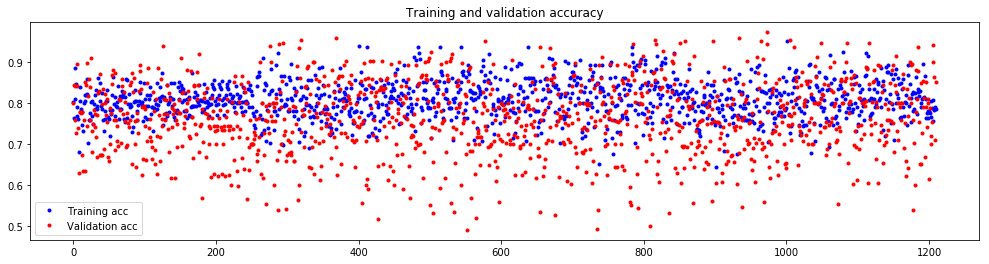

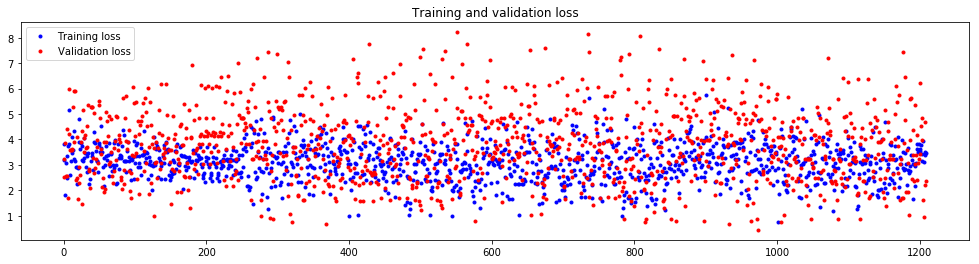

In [0]:
# Plot the accuracy and loss curves
plot_histories(histories)

In [0]:
# Create un nuevo generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=image_dataframe,
    directory=image_dir,
    x_col="id",
    y_col="label",
    class_mode="categorical",
    color_mode='rgb',
    target_size=(image_size,image_size),
    batch_size=val_batchsize,
    shuffle=True,
    subset="validation")

94/93 [==============================] - 90s 953ms/step
No of errors = 211/939 (22.470713525026625)


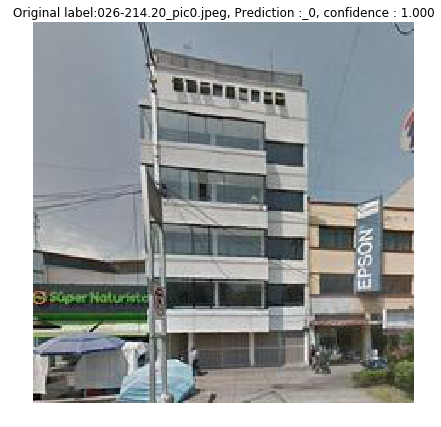

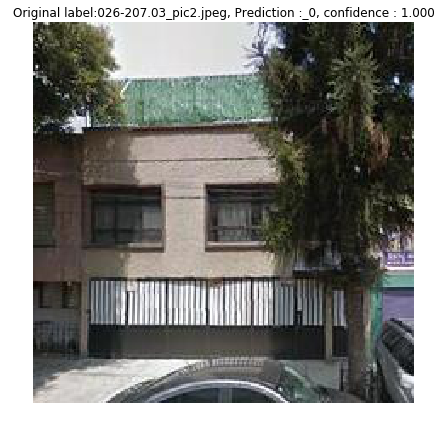

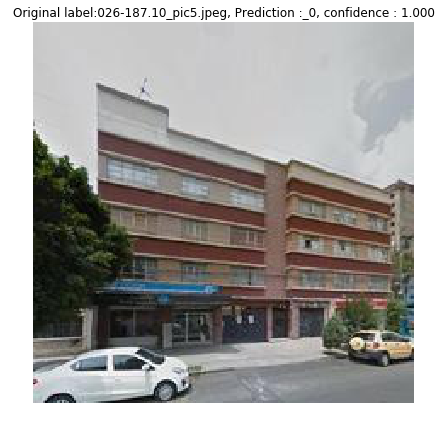

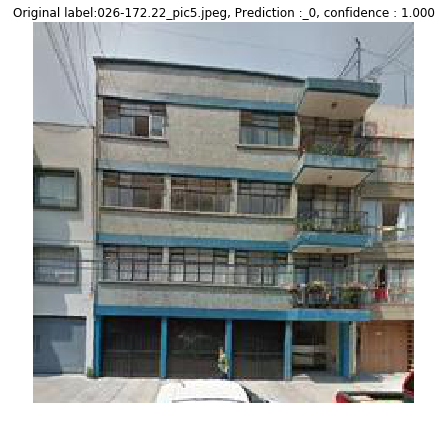

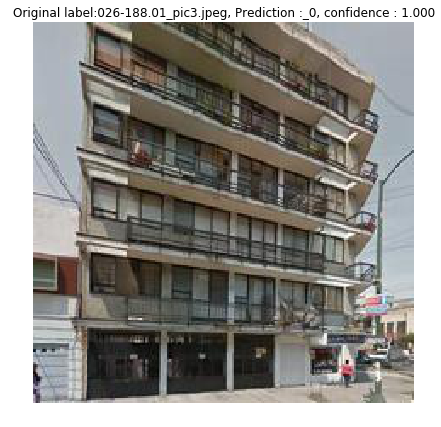

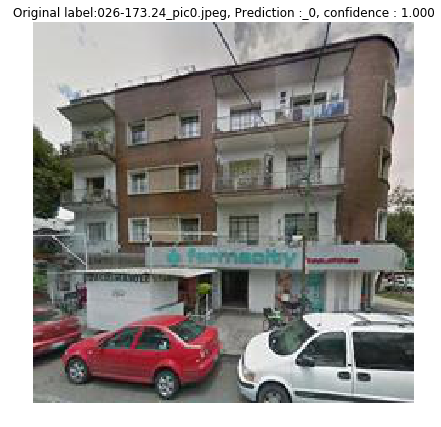

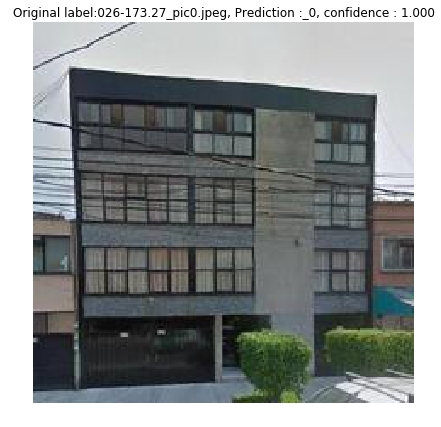

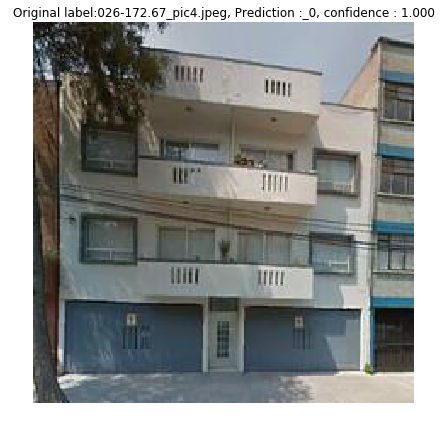

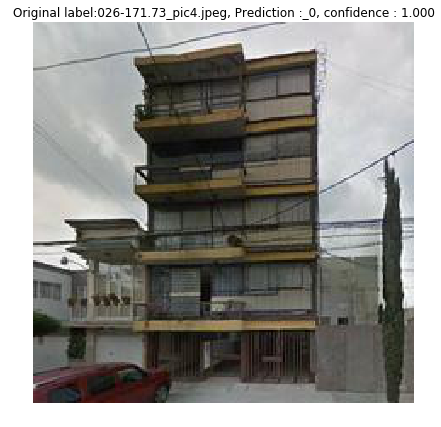

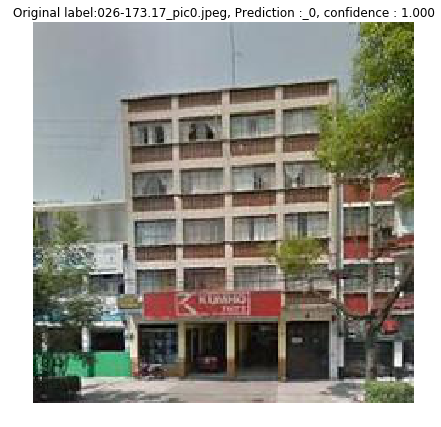

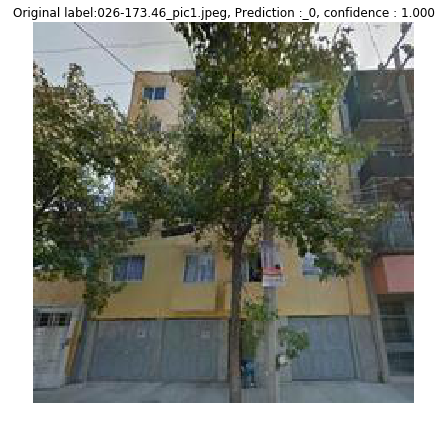

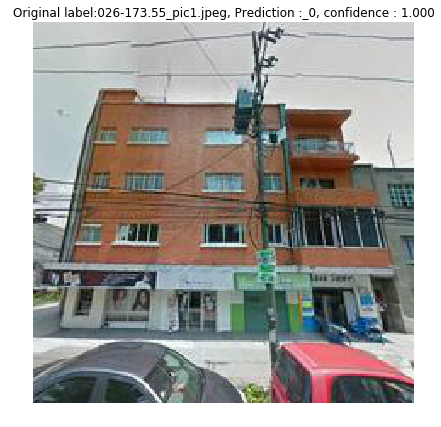

In [0]:
# hacer predicciones y mostrar los errores

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

# encontrar los errores
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{} ({})".format(len(errors),validation_generator.samples,100*len(errors)/validation_generator.samples))


# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(image_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()
    
    if i > 10:
      break

In [0]:
# encontrar los aciertos
clase = "Planta baja debil"
etiquetareal=[
        ' No',
        ' Si (20-50% muro)',
        ' Si (solo columnas)']
idx2label2 = dict((v,etiquetareal[v]) for k,v in label2index.items())

oks = np.where(predicted_classes == ground_truth)[0]
print("Numero de aciertos = {}/{} ({})".format(len(oks),validation_generator.samples,100*len(oks)/validation_generator.samples))


# Show oks
for i in range(len(oks)):
    pred_class = np.argmax(predictions[oks[i]])
    pred_label = idx2label2[pred_class]
    
    title = '{} :{}, confidence : {:.3f}'.format(
        clase,
        pred_label,
        predictions[oks[i]][pred_class])
    
    original = load_img('{}/{}'.format(image_dir,fnames[oks[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()
    
    if i > 10:
      break